In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

figsize = (14, 6)

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

#DATA_ROOT_FOLDER = '~/Data/pytorch'
DATA_ROOT_FOLDER = '/Users/brandon/Data/pytorch'

train_set = torchvision.datasets.FashionMNIST(root = f"{DATA_ROOT_FOLDER}/data", train = True, download = True, transform = transforms.ToTensor())
test_set = torchvision.datasets.FashionMNIST(root = f"{DATA_ROOT_FOLDER}/data", train = False, download = True, transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100, shuffle=False)

num_pixels = 28 * 28

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden = nn.Linear(num_pixels, 128)
        self.output = nn.Linear(128, 10)

    def forward(self, x):
        x = self.hidden(x)
        x = F.relu(x)
        
        x = self.output(x)
        return x
model = Net()

#model = torch.nn.Sequential(
#        nn.Linear(in_features=num_pixels, out_features=128),
#        nn.ReLU(),
#        nn.Linear(in_features=128, out_features=10)
#        #nn.Softmax(dim=1)
#)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else device)
model.to(device);

print(device)

mps


In [3]:
loss_func = nn.CrossEntropyLoss()

num_epochs = 4
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# for plots
loss_list = []
iteration_list = []
accuracy_list = []

count = 0
for epoch in range(num_epochs):
    for images, labels in train_loader: 
        count += 1
        
        model.train()

        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)

        train = images.view(-1, num_pixels)
        
        # Forward pass 
        outputs = model(train)
        loss = loss_func(outputs, labels)

        # back-prop
        optimizer.zero_grad()
        loss.backward()

        # optimize
        optimizer.step()

        if (count < 30) or not(count % 100):
            with torch.no_grad():
                total = 0
                correct = 0

                for images, labels in test_loader:
                    model.eval()
                    images = images.to(device)

                    test = images.view(-1, num_pixels)
                    outputs = model(test).cpu()

                    predictions = torch.max(outputs, 1)[1]
                    correct += (predictions == labels).sum().numpy()
                    total += len(labels)
                    
                accuracy = correct * 100 / total
                
                loss_list.append(loss.cpu().data)
                iteration_list.append(count)
                accuracy_list.append(accuracy)
        
                print(f'Epoch: {epoch+1:02d}, Iteration: {count:5d}, Loss: {loss.data:.4f}, Accuracy: {accuracy:.3f}%')      

print('Finished Training')

Epoch: 01, Iteration:     1, Loss: 2.3140, Accuracy: 38.090%
Epoch: 01, Iteration:     2, Loss: 2.1978, Accuracy: 43.780%
Epoch: 01, Iteration:     3, Loss: 2.1258, Accuracy: 41.050%
Epoch: 01, Iteration:     4, Loss: 2.0770, Accuracy: 40.790%
Epoch: 01, Iteration:     5, Loss: 1.9493, Accuracy: 43.030%
Epoch: 01, Iteration:     6, Loss: 1.8323, Accuracy: 49.660%
Epoch: 01, Iteration:     7, Loss: 1.7740, Accuracy: 56.010%
Epoch: 01, Iteration:     8, Loss: 1.7502, Accuracy: 59.270%
Epoch: 01, Iteration:     9, Loss: 1.6567, Accuracy: 60.220%
Epoch: 01, Iteration:    10, Loss: 1.5617, Accuracy: 59.370%
Epoch: 01, Iteration:    11, Loss: 1.5332, Accuracy: 59.900%
Epoch: 01, Iteration:    12, Loss: 1.3898, Accuracy: 61.380%
Epoch: 01, Iteration:    13, Loss: 1.3984, Accuracy: 62.830%
Epoch: 01, Iteration:    14, Loss: 1.3013, Accuracy: 63.640%
Epoch: 01, Iteration:    15, Loss: 1.3903, Accuracy: 63.830%
Epoch: 01, Iteration:    16, Loss: 1.4249, Accuracy: 63.800%
Epoch: 01, Iteration:   

In [4]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
#print("Optimizer's state_dict:")
#for var_name in optimizer.state_dict():
#    print(var_name, "\t", optimizer.state_dict()[var_name])

torch.save(model, f'{DATA_ROOT_FOLDER}/model/model.pth')
copy = torch.load(f'{DATA_ROOT_FOLDER}/model/model.pth')

Model's state_dict:
hidden.weight 	 torch.Size([128, 784])
hidden.bias 	 torch.Size([128])
output.weight 	 torch.Size([10, 128])
output.bias 	 torch.Size([10])


In [5]:
from torchsummary import summary
summary(model.to("cpu"), input_size=(1, 1, num_pixels))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1            [-1, 1, 1, 128]         100,480
            Linear-2             [-1, 1, 1, 10]           1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.39
Estimated Total Size (MB): 0.39
----------------------------------------------------------------


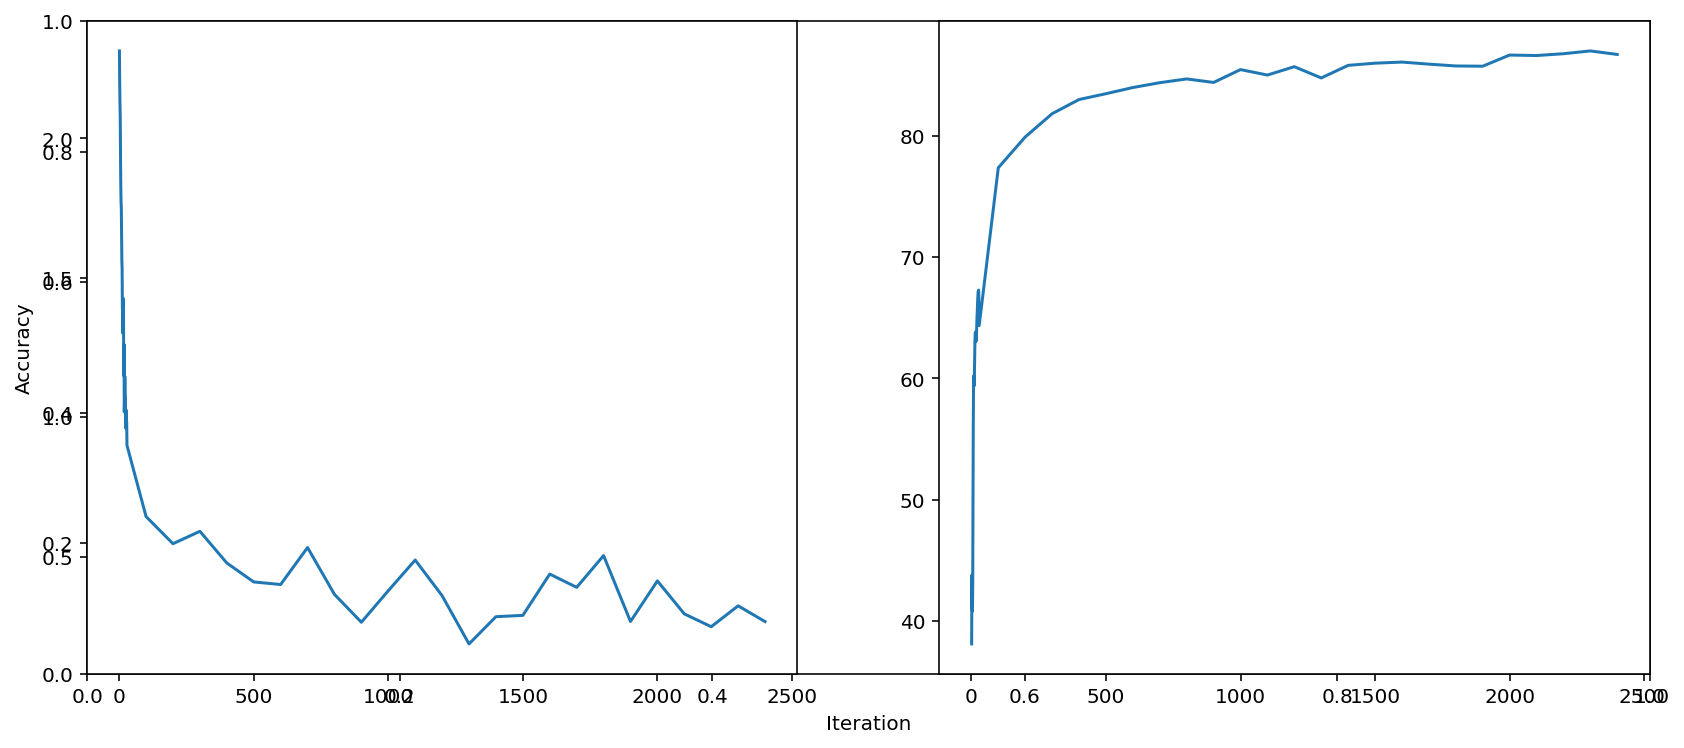

In [6]:
fig = plt.figure(figsize=figsize)
ax = fig.gca()

fig.add_subplot(1, 2, 1)
plt.plot(iteration_list, loss_list)

ax.set_xlabel('Iteration')
ax.set_ylabel('Loss')

fig.add_subplot(1, 2, 2)
plt.plot(iteration_list, accuracy_list)

ax.set_xlabel('Iteration')
ax.set_ylabel('Accuracy')

plt.show()